In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from matplotlib.patches import Rectangle
from IPython.display import display
import stumpy
import os
import zipfile
from tqdm.notebook import tqdm_notebook
from datetime import datetime
import gc
from sklearn.preprocessing import MinMaxScaler

np.set_printoptions(suppress=True)

data_directory = './data/Feb2022/' # The root directory for where all the data files are stored
overall_filename = 'february_data.csv' # Filename where the concatenated individual files will be stored

In [2]:
# Helper functions. They do what the function name suggests

def read_in_file(filename, keep_columns=None, time_format='%Y-%m-%dT%H:%M:%S.%f'):
    '''Reads in a .csv file into a Pandas DataFrame. 
    
    This function assumes there is a column in the .csv whose name is 'time'. The 'time' column is automatically set as a
    Pandas DatetimeIndex.

    Args:
        filename : str
            The name of the file to be read from, in .csv format.
        keep_columns : list str
            The names of the columns to keep from the file. If None, all columns will be kept.
        time_format: str
            The datetime format for which to parse the 'time' column from the .csv file. 

    Returns:
        A Pandas DataFrame.
    '''
    df = pd.read_csv(filename, usecols=keep_columns)

    if 'time' in df.columns.tolist():
        df.time = pd.to_datetime(df.time, format=time_format)
        df = df.set_index('time')

    return df

def groupby_second(df, agg='mean'):
    '''Groups a Pandas DataFrame by second according to the aggregation method agg.

    Args:
        df: Pandas DataFrame
            A Pandas DataFrame whose index is a DatetimeIndex. The index needs to be of this type to perform the groupby.
        agg: str
            The aggregation method for the groupby operation. Default is 'mean'.

    Returns:
        The resulting Pandas DataFrame.
    '''
    df = df.groupby(by=[df.index.year, df.index.month, df.index.day, df.index.hour, df.index.minute, df.index.second]).agg(agg)
    df.index = pd.to_datetime(df.index.get_level_values(0).astype(str) + '-' +
                df.index.get_level_values(1).astype(str) + '-' +
                df.index.get_level_values(2).astype(str) + 'T' +
                df.index.get_level_values(3).astype(str) + ':' +
                df.index.get_level_values(4).astype(str) + ':' +
                df.index.get_level_values(5).astype(str),
                format='%Y-%m-%dT%H:%M:%S')
    return df

def plot_time_window(df, t1, t2, col, title=None, fontsize=14,
                     save_fig=False, fname=None):
    '''Plots one column of a DataFrame in a certain time window.
    
    Args:
        df: Pandas DataFrame
            The DataFrame with the data to be plotted.
        t1: Datetime
            The opening of the time interval (inclusive).
        t2: Datetime
            The end of the time interval (exclusive).
        col: str
            The column of df to plot.'''
            
    df = df[(df.index >= t1) & (df.index < t2)]

    sns.lineplot(x=df.index, y=df[col])
    plt.rcParams.update({'font.size': fontsize})
    if title is not None:
        plt.title(title, fontsize=fontsize)

    if save_fig:
        plt.tight_layout()
        plt.savefig(fname, dpi=300)
        
    plt.show()

In [5]:
# Run this cell if you need to concatenate all the data files from data_directory into a csv grouped by second

out_file = 'february_data_by_second.csv'
indx_files = list(enumerate(os.listdir(data_directory)))
for i, file in tqdm_notebook( indx_files ): # For each of our february files

    if ".csv" not in file:
        continue
    
    df = read_in_file(data_directory + file, keep_columns=['time', 'Continuous Bond FFT Band 0', 'Continuous Bond FFT Band 1',
                                                        'Continuous Bond FFT Band 2', 'Continuous Bond FFT Band 3', 
                                                        'Continuous Bond FFT Band 4', 'Continuous Bond FFT Band 5', 
                                                        'Continuous Bond FFT Band 6', 'Continuous Bond FFT Band 7', 
                                                        'Continuous Bond Vibration'])
    df.fillna(inplace=True, method='ffill')
    df = groupby_second(df)

    if len(df) > 0:
        if i == 0:
            df.to_csv(out_file)
        else:
            df.to_csv(out_file, mode='a', header=False)

  0%|          | 0/310 [00:00<?, ?it/s]

In [4]:
# Run this cell if you need to concatenate all the data files from data_directory into a csv

out_file = 'february_data.csv'
indx_files = list(enumerate(os.listdir(data_directory)))
for i, file in tqdm_notebook( indx_files ): # For each of our february files

    if ".csv" not in file:
        continue
    
    df = read_in_file(data_directory + file, keep_columns=['time', 'Continuous Bond FFT Band 0', 'Continuous Bond FFT Band 1',
                                                        'Continuous Bond FFT Band 2', 'Continuous Bond FFT Band 3', 
                                                        'Continuous Bond FFT Band 4', 'Continuous Bond FFT Band 5', 
                                                        'Continuous Bond FFT Band 6', 'Continuous Bond FFT Band 7', 
                                                        'Continuous Bond Vibration'])

    if len(df) > 0:
        if i == 0:
            df.to_csv(out_file)
        else:
            df.to_csv(out_file, mode='a', header=False)

  0%|          | 0/310 [00:00<?, ?it/s]

Start of Matrix Profile Analysis

In [23]:
class MatrixProfiler():
    def __init__(self, m=3, t1=None, t2=None, fontsize=14, save_fig=False, fname=None, figsize=(18,10), normalize=True):
        self.m = m
        self.t1, self.t2 = t1, t2
        self.fontsize = fontsize
        self.save_fig = save_fig
        self.fname = fname
        self.figsize = figsize
        self.normalize = normalize

    def fit(self, df):
        self.n_dim = len(df.columns)

        if self.t1 is not None \
            and self.t2 is not None \
            and self.t1 < self.t2:
            self.df = df[(df.index >= self.t1) & (df.index < self.t2)]

        if self.normalize:
            self.df.iloc[:,:] = MinMaxScaler().fit_transform(self.df.iloc[:,:])

        if self.n_dim > 1: # If you have more than one dimension
            self.do_matrix_profile_nd()
        else:
            self.do_matrix_profile_1d()

    def do_matrix_profile_1d(self):
        '''Performs an 1-dimensional matrix profile to find motifs and discords.
        
        This function will display a PyPlot figure for the matrix profile.
        
        Args:
            df: Pandas DataFrame
                A Pandas DataFrame with exactly one column. Additionally, that column of the DataFrame needs to be of type
                float. This function will not work with non-continuos datatypes present in the DataFrame.
            m: int
                The window size for the matrix profile.
                
        Returns:
            None. Only the output is displayed.
        '''
        self.mp = stumpy.stump(self.df.iloc[:, 0], self.m)
        self.discord_idx = np.argsort(self.mp[:, 0])[-1]

    def do_matrix_profile_nd(self, df, m):
        '''Performs an n-dimensional matrix profile to find motifs, where n > 1. This function will display PyPlot figures for each dimension of the matrix profile.
        
        Args:
            df: Pandas DataFrame
                A Pandas DataFrame with more than one column and whose number of columns is greater than 1. Additionally,
                each column of the DataFrame needs to be of type float. This function will not work with non-continuos
                datatypes present in the DataFrame.
            m: int
                The window size for the matrix profile.
                
        Returns:
            None. Only the output is displayed.
        '''

        self.mp, indices = stumpy.mstump(df, m)
        self.discord_idx = np.argsort(self.mp, axis=1)[:, -1]

    def display(self):
        if self.n_dim == 1:
            nrows = 2
            figsize = self.figsize
            self.fig, self.axs = plt.subplots(nrows, sharex=True, sharey=False, gridspec_kw={'hspace': 0}, figsize=figsize)
            self.display_1d()
        else:
            nrows = self.mp.shape[0] * 2
            figsize = (18,5*self.df.shape[1])
            self.fig, self.axs = plt.subplots(nrows, sharex=True, sharey=False, gridspec_kw={'hspace': 0}, figsize=figsize)
            self.display_2d()

        if self.save_fig:
            plt.tight_layout()
            plt.savefig(self.fname, dpi=300)

        plt.show()

    def display_1d(self):
        plt.suptitle('Discord (Anomaly/Novelty) Discovery - Window Size {}'.format(self.m), fontsize=self.fontsize)
        self.axs[0].plot(self.df.iloc[:, 0].values)
        self.axs[0].set_ylabel(list(self.df.columns)[0], fontsize=self.fontsize)
        self.axs[1].set_xlabel('Time', fontsize =self.fontsize)
        self.axs[1].set_ylabel('Matrix Profile', fontsize=self.fontsize)
        self.axs[1].plot(self.mp[:, 0])

        rect = Rectangle((self.discord_idx, 0), self.m, max(self.df.iloc[:, 0]), facecolor='red', alpha=.35)
        self.axs[0].add_patch(rect)
        self.axs[1].axvline(x=self.discord_idx, linestyle="dashed", color='red', alpha=0.5)

    def display_2d(self):
        for k, dim_name in enumerate(self.df.columns):
            self.axs[k].set_ylabel(dim_name, fontsize=self.fontsize)
            self.axs[k].plot(np.arange(self.df.shape[0]), self.df[dim_name])
            self.axs[k].set_xlabel('Time', fontsize =self.fontsize)

            self.axs[k + self.mp.shape[0]].set_ylabel(dim_name.replace('T', 'P'), fontsize=self.fontsize)
            self.axs[k + self.mp.shape[0]].plot(self.mp[k], c='orange')
            self.axs[k + self.mp.shape[0]].set_xlabel('Time', fontsize =self.fontsize)

            self.axs[k].axvline(x=self.discord_idx[1], linestyle="dashed", c='black')
            self.axs[k + self.mp.shape[0]].axvline(x=self.discord_idx[1], linestyle="dashed", c='black')


In [28]:
# Read in the data from february
src_file = 'february_data.csv'
df_overall = read_in_file(src_file, keep_columns=['time', 'Continuous Bond Vibration'])
df_overall = df_overall.fillna(method='ffill') # Imputes NaNs from the last valid observation

In [27]:
# # Groupby second using the RMS function

# rms = lambda x: np.sqrt(np.mean(x**2))
# df = df_overall.dropna()
# df = groupby_second(df, rms) # Trying rms instead of mean or sum
# print(df.head())

In [40]:
# Set the parameters for later analysis

t1 = datetime(year=2022, 
              month=2, 
              day=21, 
              hour=0, 
              minute=0, 
              second=0)
t2 = datetime(year=2022,
              month=2, 
              day=22, 
              hour=0, 
              minute=0, 
              second=0)

cols = ['Continuous Bond Vibration']

print(df_overall.head())

# Plot the time window for some quick EDA
figure(figsize=(18,4))
plot_time_window(df_overall, t1, t2, cols[0])

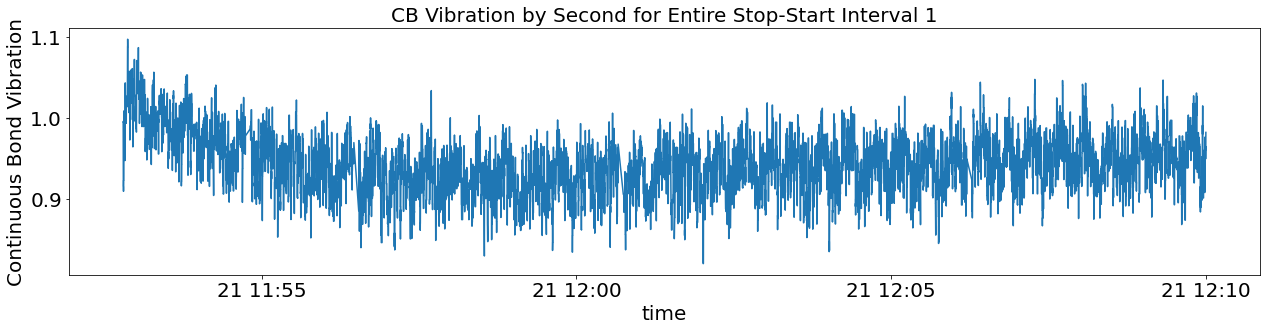

C:\Users\camer\anaconda3\envs\general\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\camer\anaconda3\envs\general\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


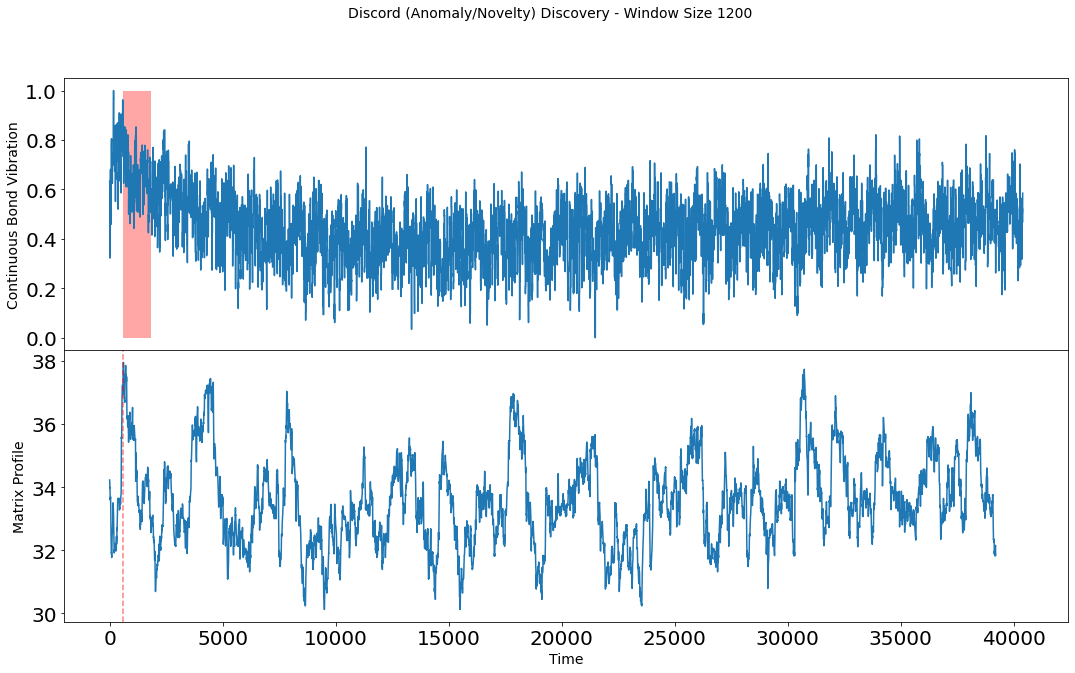

In [39]:
# Set the parameters for later analysis

t1 = datetime(year=2022, 
              month=2, 
              day=21, 
              hour=11, 
              minute=52, 
              second=48)
# t2 = datetime(year=2022,
#               month=2, 
#               day=21, 
#               hour=14, 
#               minute=31, 
#               second=10)
t2 = datetime(year=2022,
              month=2, 
              day=21, 
              hour=12, 
              minute=10, 
              second=0)

cols = ['Continuous Bond Vibration']
window_sizes = [240] # I chose these windows because it looks like the data runs in regular intervals lasting about 30 sec

# Plot the time window for some quick EDA
figure(figsize=(18,5))
plot_time_window(df_overall, t1, t2, cols[0], fontsize=20,
                 title="CB Vibration by Second for Entire Stop-Start Interval 1",
                 save_fig=True, fname="figs/cb-vibr_start-stop-interv_ex-1.png")

matrix_profiler = MatrixProfiler(m=1200, t1=t1, t2=t2)
matrix_profiler.fit(df_overall)
matrix_profiler.display()

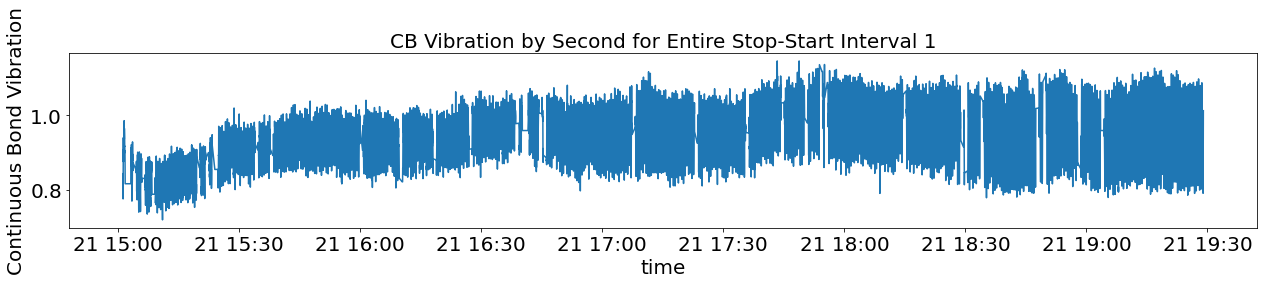

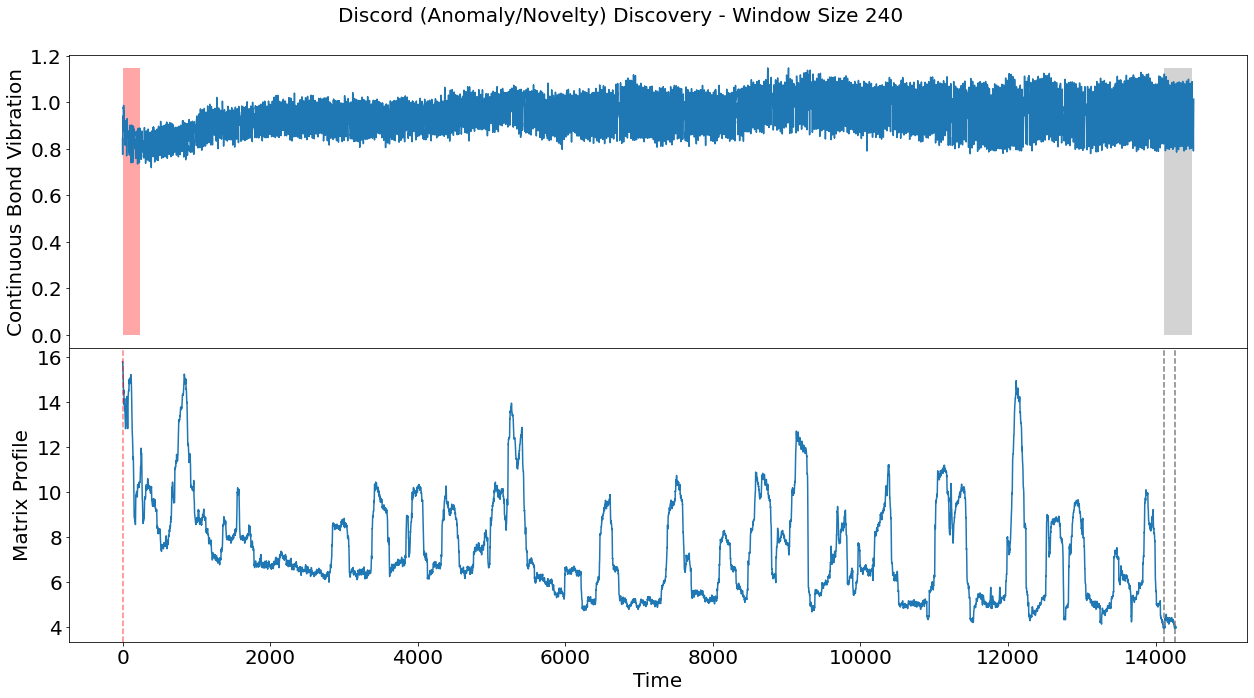

In [95]:
# Set the parameters for later analysis

t1 = datetime(year=2022, 
              month=2, 
              day=21, 
              hour=15, 
              minute=1, 
              second=13)
t2 = datetime(year=2022,
              month=2, 
              day=21, 
              hour=19, 
              minute=29, 
              second=0)

cols = ['Continuous Bond Vibration']
window_sizes = [240] # I chose these windows because it looks like the data runs in regular intervals lasting about 30 sec

# Plot the time window for some quick EDA
figure(figsize=(18,4))
plot_time_window(df, t1, t2, cols[0], impute=True, fontsize=20,
                 title="CB Vibration by Second for Entire Stop-Start Interval 1",
                 save_fig=True, fname="figs/cb-vibr_start-stop-interv_ex-2.png")

# Perform a matrix profile for the different window sizes
for m in window_sizes:
    do_matrix_profile(df[cols], m, t1, t2, impute=True, fontsize=20,
                      save_fig=True, fname="figs/cb-vibr_start-stop-interv_ex-2_mat-prof-240.png")